In [2]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_O

In [3]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import os    # file management
import pandas as pd   # data frames
import importlib   # for reloading your own files

# my own file:
already_imported = 'de' in globals()
try:
    import full_bubble_model as de
except:
    try:
        import Bubble_dynamics_simulation.full_bubble_model as de
    except:
        print(colored(f'Error, \'full_bubble_model.py\' not found', 'red'))
if already_imported: importlib.reload(de)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: no_excitation (control parameters: [])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: False


In [4]:
"""Base settings"""

directory = 'D:\\parameter_studies\\Ammonia_noexc_2D'
file_base_name = 'output_'

In [5]:
"""Load all CSV files from directory into a dataframe (all_data)"""

# create a dataframe
all_data = pd.DataFrame()
num = 0
print(f'Found files:')

# iterate trough all files in directory (including subdirectories)
for (root, dirs, files) in os.walk(directory):
    for file in files:
        # ignore python rubish
        if 'ipynb_checkpoints' in root:
            continue
        # check if it's a CSV starting with file_base_name
        if file[-4:] != '.csv':
            continue
        if file[:len(file_base_name)] != file_base_name:
            continue

        # read file
        num += 1
        current_data = pd.read_csv(os.path.join(root, file))
        print(f'\t{file: <24} ({current_data.shape[0]: >4} rows)')
        all_data = pd.concat([all_data, current_data])
    
    
# Print some stats:
print(f'_______________________________________')
print(f'total number of files: {num}')
total = all_data.shape[0]
print(f'{"total:": <10} {total: < 8} rows   ( 100.00 %)')

# Print errors
def matches(error, error_code):
    errors, success = de.get_errors(error_code)
    return error in errors

for error in de.error_codes.keys():
    digit = -1; place = -1
    for i in range(10):
        if str(i) in error:
            digit = i
            place = len(error) - error.find(str(i)) - 1

    if digit < 0 and place < 0:
        print(colored(f'Error: invalid error code: {error}', 'red'))
        continue
    num = all_data.loc[(all_data['error_code'] // (10**place) % 10) == digit].shape[0]
    if error == 'x0x':
        num  -= all_data.loc[(all_data['error_code'] % 10) == 0].shape[0] # xx0
    print(f'{error + ":": <10} {num: < 8} rows   ({(100*num/total): 7.2f} %)\t' + colored(de.error_codes[error]['describtion'], de.error_codes[error]['color']))

num = all_data.loc[(all_data['T_max'] > 6000.0)].shape[0]
print(f'too hot:   {num: < 8} rows   ({100*num/total: 7.2f} %)\t' + colored('The temperature exceeds the upper limit of NASA constants', 'yellow'))

print(f'_______________________________________')

Found files:
	output_1.csv             (2500 rows)
_______________________________________
total number of files: 1
total:      2500    rows   ( 100.00 %)
xx0:        2251    rows   (  90.04 %)	succecfully solved with LSODA solver
xx1:        246     rows   (   9.84 %)	LSODA solver didn't converge
xx2:        3       rows   (   0.12 %)	LSODA solver timed out
xx3:        0       rows   (   0.00 %)	LSODA solver had a fatal error
x0x:        203     rows   (   8.12 %)	succecfully solved with Radau solver
x4x:        46      rows   (   1.84 %)	Radau solver didn't converge (NO SOLUTION!)
x5x:        0       rows   (   0.00 %)	Radau solver timed out (NO SOLUTION!)
x6x:        0       rows   (   0.00 %)	Radau solver had a fatal error (NO SOLUTION!)
1xx:        0       rows   (   0.00 %)	Low pressure error: The pressure of the gas is negative
2xx:        1516    rows   (  60.64 %)	Low pressure warning: The pressure during the expansion is lower, than the saturated water pressure
too hot:    7 

In [6]:
"""Locate valid (good_data) and wrong (wrong_data) simulations"""

# Get valid datas
good_data = all_data.loc[
    (all_data['error_code'] % 100 <= 3) & ((all_data['error_code'] // 100) % 10 != 1) &
    (all_data['energy_efficiency'] > 0.0) & (all_data['energy_efficiency'] == all_data['energy_efficiency']) # positive not NaN
    # or set negative energy to inf: good_data.loc[good_data['energy'] < 0.0, 'energy'] = 1e10
]

# Everything that's not in good_data
wrong_data = pd.concat([good_data, all_data]).drop_duplicates(keep=False)

# Sort by energy
good_data = good_data.sort_values(['energy_efficiency'], ascending=True)

# New column
good_data['logE'] = np.log10(good_data['energy_efficiency'])
print(f'Good data: {good_data.shape[0]} rows ({100*good_data.shape[0]/all_data.shape[0]: .2f} %)')

Good data: 2433 rows ( 97.32 %)


In [7]:
"""Print some statistics"""

good_data[['ID', 'R_E', 'ratio', 'P_amb', 'alfa_M', 'T_inf', 'P_v', 'mu_L', 'gases', 'fractions', 'surfactant', 'elapsed_time', 'steps', 'collapse_time', 'T_max', f'n_{de.target_specie}', 'expansion_work', 'dissipated_acoustic_energy', 'energy_efficiency'] + de.excitation_args].describe()

,ID,R_E,ratio,P_amb,alfa_M,T_inf,P_v,mu_L,surfactant,elapsed_time,steps,collapse_time,T_max,n_NH3,expansion_work,dissipated_acoustic_energy,energy_efficiency
count,2433.000000,2433.000000,2433.000000,2433.0,2.433000e+03,2.433000e+03,2.433000e+03,2433.000000,2433.0,2433.000000,2433.000000,2.433000e+03,2433.000000,2.433000e+03,2.433000e+03,2433.0,2.433000e+03
mean,1249.154131,0.000005,5.500038,1013250.0,5.000000e-02,3.031500e+02,4.245126e+03,0.000815,1.0,3.303102,10766.798192,9.011366e-07,3397.337943,6.119298e-16,3.318247e-07,0.0,1.998667e+116
std,722.416321,0.000003,2.634932,0.0,6.940320e-18,5.685510e-14,9.096817e-13,0.000000,0.0,3.998851,3827.850137,6.318802e-07,1673.522995,1.160032e-15,6.133739e-07,0.0,9.858516e+117
min,1.000000,0.000001,1.000000,1013250.0,5.000000e-02,3.031500e+02,4.245126e+03,0.000815,1.0,0.001000,7.000000,0.000000e+00,303.150000,-2.613082e-17,0.000000e+00,0.0,1.634046e+04
25%,622.000000,0.000003,3.204082,1013250.0,5.000000e-02,3.031500e+02,4.245126e+03,0.000815,1.0,1.507990,8271.000000,4.031444e-07,1995.441282,1.164773e-28,6.605541e-09,0.0,3.657599e+04
50%,1250.000000,0.000005,5.408163,1013250.0,5.000000e-02,3.031500e+02,4.245126e+03,0.000815,1.0,2.358367,11112.000000,7.330590e-07,3730.024070,2.893616e-18,5.881441e-08,0.0,8.111999e+05
75%,1875.000000,0.000008,7.795918,1013250.0,5.000000e-02,3.031500e+02,4.245126e+03,0.000815,1.0,3.058621,13678.000000,1.275529e-06,4818.996607,5.942824e-16,3.419350e-07,0.0,3.586931e+15
max,2500.000000,0.000010,10.000000,1013250.0,5.000000e-02,3.031500e+02,4.245126e+03,0.000815,1.0,43.562581,24837.000000,3.872447e-06,6062.319398,5.258947e-15,4.219266e-06,0.0,4.862757e+119


In [9]:
"""Plot a certain simulation"""

# converts a line of all_data to a dictionary containing the control parameters (cpar)
def line_to_dict(line):
    # check 'full_bubble_model.py' settings
    if (de.enable_heat_transfer != line['enable_heat_transfer'] or
        de.enable_evaporation != line['enable_evaporation'] or
        de.enable_reactions != line['enable_reactions'] or
        de.enable_dissipated_energy != line['enable_dissipated_energy'] or
        de.target_specie != line['target_specie'] or
        de.excitation_type != line['excitation_type']):
        print(colored(f'Error: the settings of \'full_bubble_model.py\' do not match the current settings', 'red'))

    gases = str(line['gases'])
    gases = [int(index) for index in gases.split(' ') if index != '']
    fractions = str(line['fractions'])
    fractions = [float(frac) for frac in fractions.split(' ') if frac != '']

    cpar = de.dotdict(dict(
        ID = line['ID'],                  # ID of control parameter (not used during calculation)
    # Initial conditions:
        R_E = line['R_E'],                # bubble equilibrium radius [m]
        ratio = line['ratio'],            # initial radius / equilibrium radius R_0/R_E [-]
        gases = gases,                    # indexes of species in initial bubble (list of species indexes)
        fractions = fractions,            # molar fractions of species in initial bubble (list of fractions for every gas)
    # Ambient parameters:
        P_amb = line['P_amb'],            # ambient pressure [Pa]
        T_inf = line['T_inf'],            # ambient temperature [K]
    # Liquid parameters:
        alfa_M = line['alfa_M'],          # water accommodation coefficient [-]
        P_v = line['P_v'],                # vapour pressure [Pa]
        mu_L = line['mu_L'],              # dynamic viscosity [Pa*s]
        c_L = line['c_L'],                # sound speed [m/s]
        surfactant = line['surfactant'],  # surfactant (surface tension modfier) [-]
    ))

    # Excitation parameters:
    for arg in de.excitation_args:
        cpar[arg] = line[arg]

    return cpar

cpar = line_to_dict(good_data.iloc[0])   # choose the most energy efficient one
#de.plot(cpar, plot_pressure=True)

<Axes: title={'center': 'Energy efficiency distribution'}, ylabel='Frequency'>

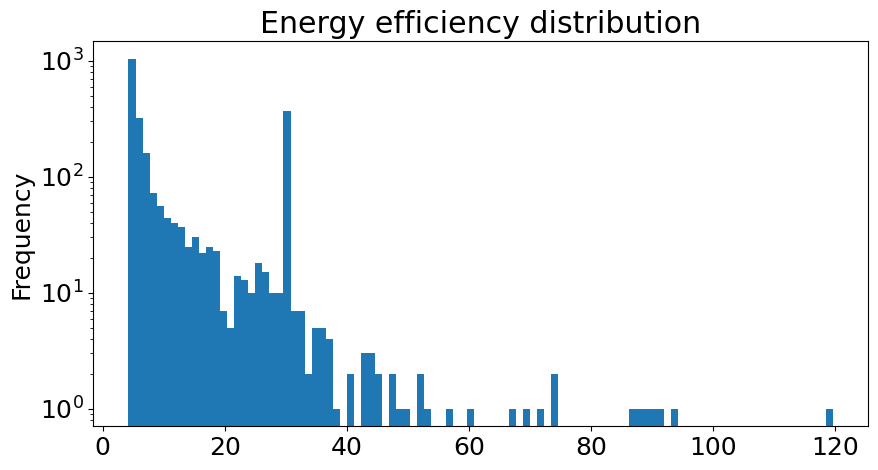

In [8]:
good_data['logE']=np.log10(good_data['energy_efficiency'])
good_data['logE'].plot.hist(bins=100, figsize=(10, 5), logy=True, title='Energy efficiency distribution')

In [9]:
good_data = good_data.sort_values(['ID'], ascending=True)
ID = list(good_data['ID'])
logE = list(good_data['logE'])
R_E = list(good_data['R_E'])
ratio = list(good_data['ratio'])
combined = [(x, y) for x, y in zip(R_E, ratio)]
xlist = good_data['R_E'].unique()
ylist = good_data['ratio'].unique()
xlist.sort()
ylist.sort()
print(f'{len(xlist)=}; {len(ylist)=}')

len(xlist)=50; len(ylist)=50


In [12]:
vmin = min(logE)
vmax = 2.0*vmin
X, Y = np.meshgrid(xlist, ylist)
Z = np.zeros(X.shape)
for i, x in enumerate(xlist):
    for j, y in enumerate(ylist):
        if (x, y) in combined:
            index = combined.index((x, y))
            if (logE[index-1] < vmax and vmin + 2.0 < logE[index] and 
                j != 0 and j != len(ylist)-1 and
                logE[index] > 1.0+logE[index+1] and logE[index] > 1.0+logE[index-1]):

                logE[index] = (logE[index-1] + logE[index+1]) / 2
                print(f'{index}: R_E={1e6*x : .2f}, ratio={y: .2f}, logE={logE[index]: .3f}')
            if (j == 0 or j == len(ylist)-1) and (i != 0 and i != len(xlist)-1 and i != len(xlist)-2):
                if (logE[index] > 1.0+logE[index+len(ylist)] and logE[index] > 1.0+logE[index-len(ylist)]
                    and logE[index] > 1.0+logE[index+len(ylist)] and logE[index] > 1.0+logE[index-len(ylist)]):

                    logE[index] = (logE[index-len(ylist)] + logE[index+len(ylist)]) / 2
                    print(f'{index}: R_E={1e6*x : .2f}, ratio={y: .2f}, logE={logE[index]: .3f}')
            Z[j, i] = logE[index]
        else:
            index = i * len(ylist) + j
            extrapolation = (logE[index-1] + logE[index]) / 2
            combined = combined[:index] + [(x, y)] + combined[index:]
            logE = logE[:index] + [extrapolation] + logE[index:]
            #Z[j, i] = logE[index]


349: R_E= 2.10, ratio= 10.00, logE= 4.494
450: R_E= 2.65, ratio= 1.00, logE= 17.191
700: R_E= 3.57, ratio= 1.00, logE= 17.164
800: R_E= 3.94, ratio= 1.00, logE= 23.584
1400: R_E= 6.14, ratio= 1.00, logE= 17.281
1500: R_E= 6.51, ratio= 1.00, logE= 17.296


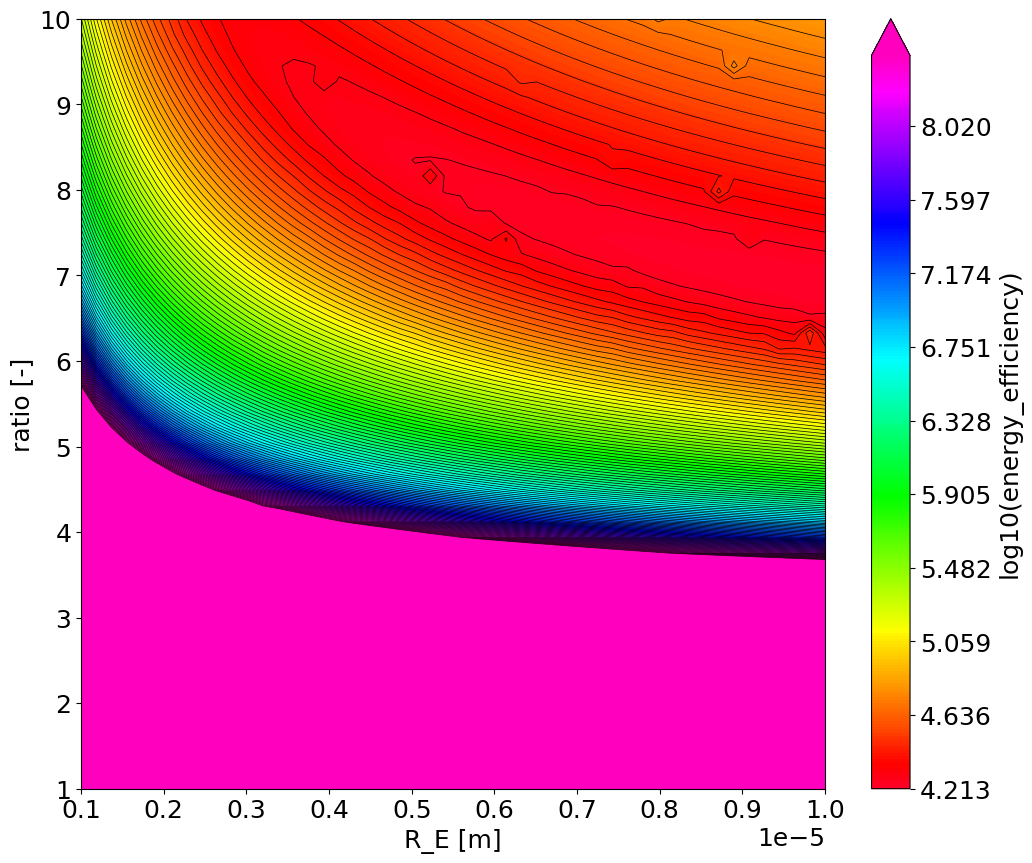

In [13]:
fig,ax=plt.subplots(1, 1, figsize=(12, 10))
levels = None
levels = np.linspace(vmin, vmax, 250)
cp = ax.contourf(X, Y, Z, levels=levels, cmap='gist_rainbow', vmax=vmax, extend='max')
ax.contour(X, Y, Z, levels=np.linspace(vmin, vmax, 100), colors='black', linewidths=0.5)
fig.colorbar(cp, label='log10(energy_efficiency)') # Add a colorbar to a plot
#ax.set_title('log10(energy_efficiency)')
ax.set_xlabel('R_E [m]')
ax.set_ylabel('ratio [-]')
plt.show()

In [128]:
good_data['R'] = 1e6*good_data['R_E']
good_data.loc[good_data['R_E'] == xlist[2], ['R', 'ratio', 'logE']]

,R,ratio,logE
85,1.367347,1.000000,30.000000
90,1.367347,1.183673,30.000000
92,1.367347,1.367347,30.000000
95,1.367347,1.551020,30.000000
97,1.367347,1.734694,30.000000
98,1.367347,1.918367,30.000000
100,1.367347,2.102041,30.000000
105,1.367347,2.285714,30.000000
104,1.367347,2.469388,37.106682
107,1.367347,2.653061,31.633606
